# Clip-Voronoi Cells
The goal is to clip Voronoi-Cells with a given boundary.
The ridges with infinite extent cannot be used to calculate the volumes of the cells.
Therefore, we try to clip the cells to get rid of infinte ridges.

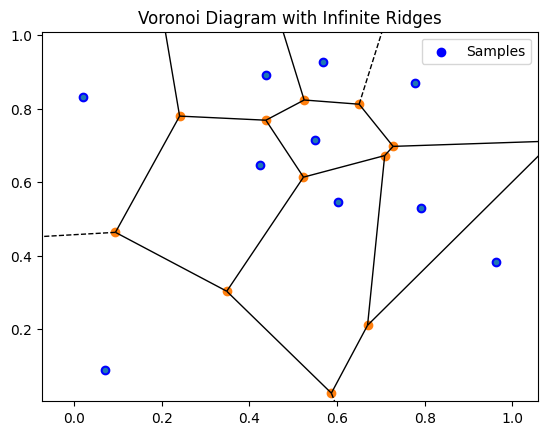

In [ ]:
# Import necessary libraries
import sys
sys.path.extend(["../../"])
from src.para_voro import *
from src.para_voro_plots import *

# Create a sample dataset with 10 samples
np.random.seed(0)
points = np.random.rand(10, 2)

# Build the Voronoi diagram
vor = Voronoi(points)

# Plot the Voronoi diagram including infinite ridges
plt.close()
fig = voronoi_plot_2d(vor)
plt.scatter(points[:, 0], points[:, 1], c='blue', label='Samples')
plt.legend()
plt.title('Voronoi Diagram with Infinite Ridges')
plt.show()


# Identify regions that have infinity edges and find adjacencies

In [2]:
[point_idx_region_mapping, region_idx_point_idx_mapping, regions_with_infinity_edges, 
 region_idx_neighboring_regions_indices_mapping, 
 region_idx_ridge_indices_mapping] = identify_infinity_regions_and_neighbors(vor)

# Print or use the results as needed
print("Regions with infinity edges:", regions_with_infinity_edges)
print("Neighboring cells for each point:", region_idx_neighboring_regions_indices_mapping)


Regions with infinity edges: [np.int64(1), np.int64(9), np.int64(0), np.int64(10), np.int64(4)]
Neighboring cells for each point: {0: [np.int64(1), np.int64(2), np.int64(8), np.int64(10)], 1: [np.int64(0), np.int64(2), np.int64(3), np.int64(4)], 2: [np.int64(0), np.int64(1), np.int64(3), np.int64(7), np.int64(8)], 3: [np.int64(1), np.int64(2), np.int64(4), np.int64(7)], 4: [np.int64(1), np.int64(3), np.int64(7), np.int64(9)], 6: [np.int64(7), np.int64(8), np.int64(9), np.int64(10)], 7: [np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(8), np.int64(9)], 8: [np.int64(0), np.int64(2), np.int64(6), np.int64(7), np.int64(10)], 9: [np.int64(4), np.int64(6), np.int64(7), np.int64(10)], 10: [np.int64(0), np.int64(6), np.int64(8), np.int64(9)]}


# Plot neighbors

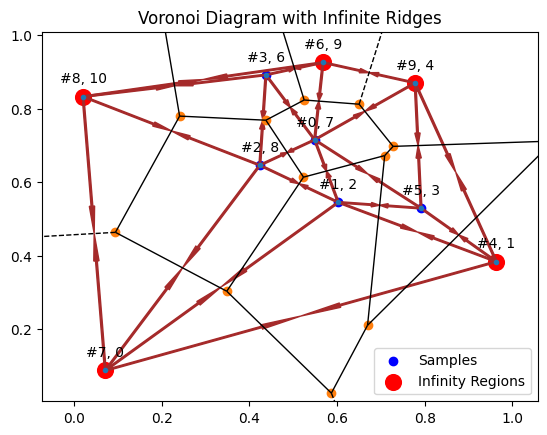

In [3]:
import matplotlib.patches as patches

plt.close()
fig = voronoi_plot_2d(vor)

ax = fig.gca()

ax.scatter(points[:, 0], points[:, 1], c="blue", label="Samples")

points_with_infinity_edges = points[[region_idx_point_idx_mapping[region_idx] for region_idx in regions_with_infinity_edges]]
ax.scatter(points_with_infinity_edges[:, 0], points_with_infinity_edges[:, 1], c="red", label="Infinity Regions", s=2**7)

for point_idx, point in enumerate(points):
    region_idx = point_idx_region_mapping[point_idx]

    ax.annotate(f"#{point_idx}, {region_idx}", xy=point, textcoords='offset points', xytext=(0,10), ha='center')

# draw arrows to neighbors
for point_idx, point in enumerate(points):
    region_idx = point_idx_region_mapping[point_idx]

    for neighbor_region_idx in region_idx_neighboring_regions_indices_mapping[region_idx]:
        neighbor_point_idx = region_idx_point_idx_mapping[neighbor_region_idx]
        neighbor_point = points[neighbor_point_idx]

        midpoint = point + (neighbor_point - point) / 2.0

        # Draw arrow from current point to neighbor point
        arrow = patches.Arrow(point[0], point[1], midpoint[0] - point[0], midpoint[1] - point[1], 
                              width=0.02, color="brown", linestyle="-")
        ax.add_patch(arrow)

plt.legend()
plt.title('Voronoi Diagram with Infinite Ridges')
plt.show()

# Clip infinity ridges with bounding box
We do this by constructing the clipped Voronoi-Cell and extract the simplex of each infinity ridge (which now should be finite). 
1. Construct all halfspace definitions for the voronoi-cell.
5. Add halfspace definitions for bbox.
6. Compute intersection points.
7. Construct convex-hull of intersection points.
8. Find simplex that belongs to infinity ridge.
9. Replace infinity ridge vertices with the vertices of the simplex.

In [4]:
# get region with infinity edges
region_idx = regions_with_infinity_edges[0]

# 1. Construct all halfspace definitions for the voronoi-cell.
# region_vertices_indices = np.asarray(vor.regions[region_idx])
region_point_idx = region_idx_point_idx_mapping[region_idx]
cur_point = vor.points[region_point_idx]
# find neighboring points with which we share an infinity edge
ridges = region_idx_ridge_indices_mapping[region_idx]
# find ridges with infinity edges
ridge_indices_of_region_with_infinity = []
ridge_indices_of_region_with_finite = []
for i in range(len(ridges)):
    if -1 in vor.ridge_vertices[ridges[i]]:
        ridge_indices_of_region_with_infinity.append(ridges[i])
    else:
        ridge_indices_of_region_with_finite.append(ridges[i])
# map ridges of region to points
infinity_ridges_point_indices = vor.ridge_points[ridge_indices_of_region_with_infinity]
finite_ridges_point_indices = vor.ridge_points[ridge_indices_of_region_with_finite]
# get other points
other_point_indices_of_infinite = infinity_ridges_point_indices.flatten()[infinity_ridges_point_indices.flatten() != region_point_idx]
other_point_indices_of_finite = finite_ridges_point_indices.flatten()[finite_ridges_point_indices.flatten() != region_point_idx]
# compute normal per ridge
other_points_infinite = vor.points[other_point_indices_of_infinite]
other_points_finite = vor.points[other_point_indices_of_finite]
normals_not_normed_infinite = other_points_infinite - cur_point
mid_points_infinite = cur_point + (normals_not_normed_infinite / 2.0)  # points on halfspace
normals_not_normed_lengths_infinite = np.linalg.norm(normals_not_normed_infinite, axis=-1)
normals_infinite = (normals_not_normed_infinite.T / normals_not_normed_lengths_infinite).T
infinity_ridge_halfspaces = np.array([compute_halfspace_equation_from_normal_and_point(normal=n, point=p) 
                                      for n, p in zip(normals_infinite, mid_points_infinite)])
normals_not_normed_finite = other_points_finite - cur_point
mid_points_finite = cur_point + (normals_not_normed_finite / 2.0)  # points on halfspace
normals_not_normed_lengths_finite = np.linalg.norm(normals_not_normed_finite, axis=-1)
normals_finite = (normals_not_normed_finite.T / normals_not_normed_lengths_finite).T
finite_ridge_halfspaces = np.array([compute_halfspace_equation_from_normal_and_point(normal=n, point=p) 
                                      for n, p in zip(normals_finite, mid_points_finite)])
combined_halfspaces = np.vstack([finite_ridge_halfspaces, infinity_ridge_halfspaces])

In [5]:
# 5. Add halfspace definitions for aabbox.
aabbox = np.array([
    [-0, 1.2],
    [-0.2, 1.2]
])

aabbox_equations = construct_halfspace_definition_for_aabbox(aabbox)

final_halfspaces = np.vstack([aabbox_equations, combined_halfspaces])

In [6]:
# 6. Compute intersection points.
hi = HalfspaceIntersection(halfspaces=final_halfspaces, interior_point=cur_point)
intersections = hi.intersections

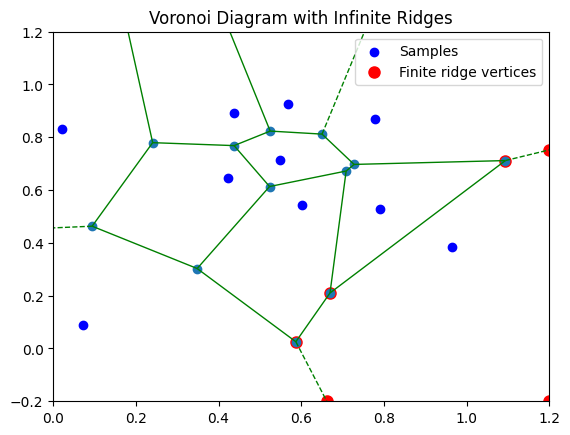

In [7]:
plt.close()
fig = plt.figure()
ax = fig.gca()
ax.scatter(points[:, 0], points[:, 1], c='blue', label='Samples')

voronoi_plot_2d(vor, show_vertices=True, show_points=False, line_colors="green", ax=ax)

ax.scatter(intersections[:, 0], intersections[:, 1], c="red", label="Finite ridge vertices", s=2**6)

ax.set_xlim(aabbox[0])
ax.set_ylim(aabbox[1])

plt.legend()
plt.title('Voronoi Diagram with Infinite Ridges')
plt.show()

In [8]:
# 7. Construct convex-hull of intersection points.
chi = ConvexHull(intersections)

# 8. Find simplex that belongs to infinity ridge.
# They should have the same equation!
ridge_indices_with_finite_vertices = []
ridge_simplices_indices = []

for j, ridge_idx in enumerate(ridge_indices_of_region_with_infinity):
    ridge_halfspace_definition = infinity_ridge_halfspaces[j]

    simplex_index = -1

    for i, eq in enumerate(chi.equations):
        all_close = np.allclose(eq, ridge_halfspace_definition)

        if all_close:
            # found matching halfspace definition
            simplex_index = i
            break
    
    if simplex_index != -1:
        # 9. Replace infinity ridge vertices with the vertices of the simplex.
        ridge_indices_with_finite_vertices.append(ridge_idx)
        ridge_simplices_indices.append(simplex_index)
        # ridge_indices_finite_vertices_mapping[ridge_idx] = chi.points[chi.simplices[simplex_index]]

finite_ridge_vertices = [chi.points[chi.simplices[i]] for i in ridge_simplices_indices]

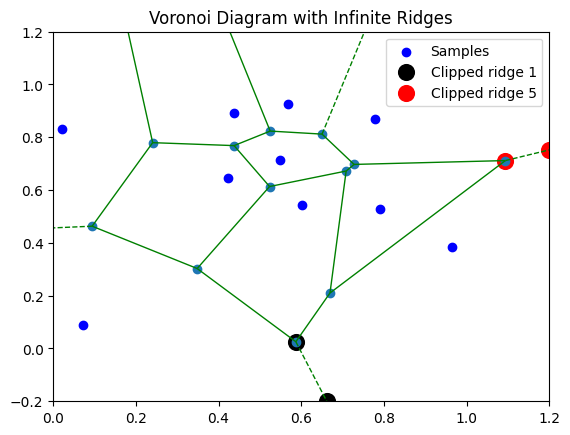

In [9]:
plt.close()
fig = plt.figure()
ax = fig.gca()
ax.scatter(points[:, 0], points[:, 1], c='blue', label='Samples')

voronoi_plot_2d(vor, show_vertices=True, show_points=False, line_colors="green", ax=ax)

colors = ["black", "red", "purple"]

for i, [ridge_idx, clipped_ridge_vertices] in enumerate(zip(ridge_indices_with_finite_vertices, finite_ridge_vertices)):
    ax.scatter(clipped_ridge_vertices[:, 0], clipped_ridge_vertices[:, 1], c=colors[i], label=f"Clipped ridge {ridge_idx}", s=2**7)

ax.set_xlim(aabbox[0])
ax.set_ylim(aabbox[1])

plt.legend()
plt.title('Voronoi Diagram with Infinite Ridges')
plt.show()

# Example performing it on all ridge vertices

In [10]:
clip_equations = construct_halfspace_definition_for_aabbox(aabbox)

new_vertices_and_ridge_indices = [clip_ridges_of_voronoi_region(
    regions_with_infinity_edges[i], vor, clip_equations, region_idx_point_idx_mapping, 
    region_idx_ridge_indices_mapping, include_finite_ridge=True)[1]
    for i in range(len(regions_with_infinity_edges))]

# combine them
ridge_indices = []
new_vertices = []

for vertices_, ridge_indices_ in new_vertices_and_ridge_indices:
    for vertices, ridge_index in zip(vertices_, ridge_indices_):
        if ridge_index not in ridge_indices:
            ridge_indices.append(ridge_index)
            new_vertices.append(vertices)

c:\Users\bauerrn\Projekte\VoroParaSense\examples\notebooks\../..\src\para_voro.py:308: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  d = np.dot(points[i], ridge_halfspace_definition[:-1]) + ridge_halfspace_definition[-1]


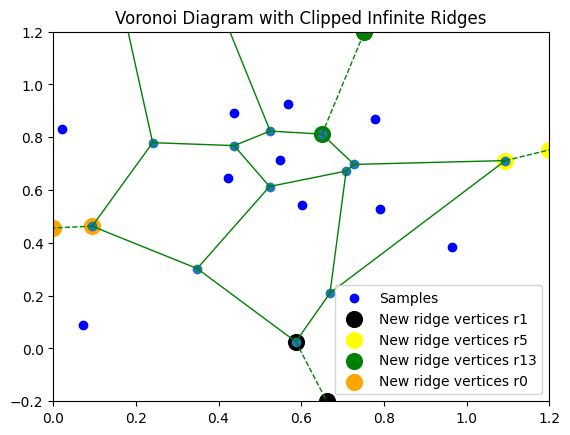

In [11]:
plt.close()
fig = plt.figure()
ax = fig.gca()
ax.scatter(points[:, 0], points[:, 1], c='blue', label='Samples')

voronoi_plot_2d(vor, show_vertices=True, show_points=False, line_colors="green", ax=ax)

color = ["black", "yellow", "green", "orange", "purple", "gray"]

for i, [vertices, ridge_index] in enumerate(zip(new_vertices, ridge_indices)):
    ax.scatter(vertices[:, 0], vertices[:, 1], c=color[i], label=f"New ridge vertices r{ridge_index}", s=2**7)

ax.set_xlim(aabbox[0])
ax.set_ylim(aabbox[1])

plt.legend()
plt.title('Voronoi Diagram with Clipped Infinite Ridges')
plt.show()

# Also clip finite ridges

In [12]:
clip_equations = construct_halfspace_definition_for_aabbox(aabbox)

new_vertices_and_ridge_indices = [clip_ridges_of_voronoi_region(
    i, vor, clip_equations, region_idx_point_idx_mapping, 
    region_idx_ridge_indices_mapping, include_finite_ridge=True, include_infinity_ridges=True)
    for i in region_idx_point_idx_mapping.keys()]

# combine them
finite_ridge_indices = []
finite_new_vertices = []

for vertices_, ridge_indices_ in [nvr[0] for nvr in new_vertices_and_ridge_indices]:
    for vertices, ridge_index in zip(vertices_, ridge_indices_):
        if ridge_index not in finite_ridge_indices:
            finite_ridge_indices.append(ridge_index)
            finite_new_vertices.append(vertices)

infinite_ridge_indices = []
infinite_new_vertices = []

for vertices_, ridge_indices_ in [nvr[1] for nvr in new_vertices_and_ridge_indices]:
    for vertices, ridge_index in zip(vertices_, ridge_indices_):
        if ridge_index not in infinite_ridge_indices:
            infinite_ridge_indices.append(ridge_index)
            infinite_new_vertices.append(vertices)

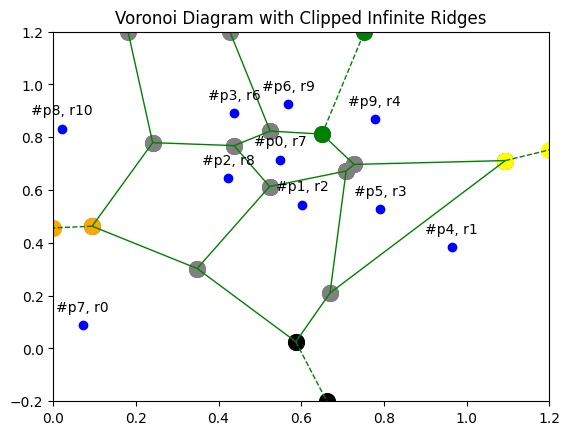

In [13]:
plt.close()
fig = plt.figure()
ax = fig.gca()
ax.scatter(points[:, 0], points[:, 1], c='blue', label='Samples')

voronoi_plot_2d(vor, show_vertices=False, show_points=False, line_colors="green", ax=ax)

color = ["black", "yellow", "green", "orange", "purple", "gray", "blue", "red", "black", "yellow", "green"]

for point_idx, point in enumerate(points):
    region_idx = point_idx_region_mapping[point_idx]

    ax.annotate(f"#p{point_idx}, r{region_idx}", xy=point, textcoords='offset points', xytext=(0,10), ha='center')

for i, [vertices, ridge_index] in enumerate(zip(finite_new_vertices, finite_ridge_indices)):
    ax.scatter(vertices[:, 0], vertices[:, 1], c="gray", label=f"New finite ridge vertices r{ridge_index}", s=2**7)

for i, [vertices, ridge_index] in enumerate(zip(infinite_new_vertices, infinite_ridge_indices)):
    ax.scatter(vertices[:, 0], vertices[:, 1], c=color[i], label=f"New infinite ridge vertices r{ridge_index}", s=2**7)

ax.set_xlim(aabbox[0])
ax.set_ylim(aabbox[1])

# plt.legend()
plt.title('Voronoi Diagram with Clipped Infinite Ridges')
plt.show()

# Clip With Convex Hull Instead of aabbox

In [14]:
clip_convex_hull = ConvexHull(points)

verts = clip_convex_hull.points[clip_convex_hull.vertices]
clip_hull_bbox = np.vstack([np.min(verts, axis=0), np.max(verts, axis=0)]).T

clip_equations = construct_halfspace_definition_for_aabbox(clip_hull_bbox)
clip_equations = np.vstack([clip_equations, clip_convex_hull.equations])

new_vertices_and_ridge_indices = [clip_ridges_of_voronoi_region(
    i, vor, clip_equations, region_idx_point_idx_mapping, 
    region_idx_ridge_indices_mapping, include_finite_ridge=True, include_infinity_ridges=True)
    for i in region_idx_point_idx_mapping.keys()]

# combine them
finite_ridge_indices = []
finite_new_vertices = []

for vertices_, ridge_indices_ in [nvr[0] for nvr in new_vertices_and_ridge_indices if nvr[0][0] is not None]:
    for vertices, ridge_index in zip(vertices_, ridge_indices_):
        if ridge_index not in finite_ridge_indices:
            finite_ridge_indices.append(ridge_index)
            finite_new_vertices.append(vertices)

infinite_ridge_indices = []
infinite_new_vertices = []

for vertices_, ridge_indices_ in [nvr[1] for nvr in new_vertices_and_ridge_indices if nvr[1][0] is not None]:
    for vertices, ridge_index in zip(vertices_, ridge_indices_):
        if ridge_index not in infinite_ridge_indices:
            infinite_ridge_indices.append(ridge_index)
            infinite_new_vertices.append(vertices)

n cliped finite ridges: 16
n cliped infinite ridges: 2


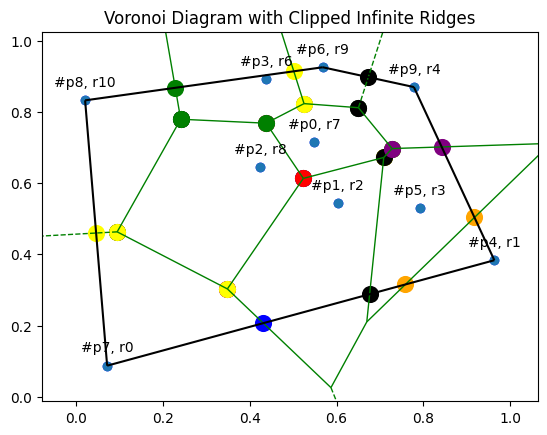

In [15]:
plt.close()
fig = plt.figure()
ax = fig.gca()
ax.scatter(points[:, 0], points[:, 1], c='blue', label='Samples')

voronoi_plot_2d(vor, show_vertices=False, show_points=False, line_colors="green", ax=ax)
convex_hull_plot_2d(hull=clip_convex_hull, ax=ax)

color = ["black", "yellow", "green", "orange", "purple", "gray", "blue", "red", "black", "yellow", "green"]

for point_idx, point in enumerate(points):
    region_idx = point_idx_region_mapping[point_idx]

    ax.annotate(f"#p{point_idx}, r{region_idx}", xy=point, textcoords='offset points', xytext=(0,10), ha='center')

for i, [vertices, ridge_index] in enumerate(zip(finite_new_vertices, finite_ridge_indices)):
    ax.scatter(vertices[:, 0], vertices[:, 1], c=(color + color)[i], label=f"New finite ridge vertices r{ridge_index}", s=2**7)

for i, [vertices, ridge_index] in enumerate(zip(infinite_new_vertices, infinite_ridge_indices)):
    ax.scatter(vertices[:, 0], vertices[:, 1], c=color[i], label=f"New infinite ridge vertices r{ridge_index}", s=2**7)#

print(f"n cliped finite ridges: {len(finite_ridge_indices)}")
print(f"n cliped infinite ridges: {len(infinite_ridge_indices)}")
v = 0.1
ax.set_xlim([clip_hull_bbox[0, 0] - v, clip_hull_bbox[0, 1] + v])
ax.set_ylim([clip_hull_bbox[1, 0] - v, clip_hull_bbox[1, 1] + v])

# plt.legend()
plt.title('Voronoi Diagram with Clipped Infinite Ridges')
plt.show()

# Alternative approach to map intersection points to halfspaces
The previous approach required to compute the full convex hull which may take forever.
Maybe the following approach is faster?

In [16]:
# get region with infinity edges
region_idx = regions_with_infinity_edges[0]

# 1. Construct all halfspace definitions for the voronoi-cell.
# region_vertices_indices = np.asarray(vor.regions[region_idx])
region_point_idx = region_idx_point_idx_mapping[region_idx]
cur_point = vor.points[region_point_idx]
# find neighboring points with which we share an infinity edge
ridges = region_idx_ridge_indices_mapping[region_idx]
# find ridges with infinity edges
ridge_indices_of_region_with_infinity = []
ridge_indices_of_region_with_finite = []
for i in range(len(ridges)):
    if -1 in vor.ridge_vertices[ridges[i]]:
        ridge_indices_of_region_with_infinity.append(ridges[i])
    else:
        ridge_indices_of_region_with_finite.append(ridges[i])
# map ridges of region to points
infinity_ridges_point_indices = vor.ridge_points[ridge_indices_of_region_with_infinity]
finite_ridges_point_indices = vor.ridge_points[ridge_indices_of_region_with_finite]
# get other points
other_point_indices_of_infinite = infinity_ridges_point_indices.flatten()[infinity_ridges_point_indices.flatten() != region_point_idx]
other_point_indices_of_finite = finite_ridges_point_indices.flatten()[finite_ridges_point_indices.flatten() != region_point_idx]
# compute normal per ridge
other_points_infinite = vor.points[other_point_indices_of_infinite]
other_points_finite = vor.points[other_point_indices_of_finite]
normals_not_normed_infinite = other_points_infinite - cur_point
mid_points_infinite = cur_point + (normals_not_normed_infinite / 2.0)  # points on halfspace
normals_not_normed_lengths_infinite = np.linalg.norm(normals_not_normed_infinite, axis=-1)
normals_infinite = (normals_not_normed_infinite.T / normals_not_normed_lengths_infinite).T
infinity_ridge_halfspaces = np.array([compute_halfspace_equation_from_normal_and_point(normal=n, point=p) 
                                      for n, p in zip(normals_infinite, mid_points_infinite)])
normals_not_normed_finite = other_points_finite - cur_point
mid_points_finite = cur_point + (normals_not_normed_finite / 2.0)  # points on halfspace
normals_not_normed_lengths_finite = np.linalg.norm(normals_not_normed_finite, axis=-1)
normals_finite = (normals_not_normed_finite.T / normals_not_normed_lengths_finite).T
finite_ridge_halfspaces = np.array([compute_halfspace_equation_from_normal_and_point(normal=n, point=p) 
                                      for n, p in zip(normals_finite, mid_points_finite)])
combined_halfspaces = np.vstack([finite_ridge_halfspaces, infinity_ridge_halfspaces])

# 2. Add halfspace definitions for aabbox.
aabbox = np.array([
    [-0, 1.2],
    [-0.2, 1.2]
])

aabbox_equations = construct_halfspace_definition_for_aabbox(aabbox)

final_halfspaces = np.vstack([aabbox_equations, combined_halfspaces])

# 3. Compute intersection points.
hi = HalfspaceIntersection(halfspaces=final_halfspaces, interior_point=cur_point)
intersections = hi.intersections

In [17]:
# 4. For each halfspace, identify points that lie on it.
# (Instead of constructing convex-hull of intersection points and mapping the equations)
finite_ridge_vertices, valid_halfspaces = map_points_to_hyperplanes(intersections, infinity_ridge_halfspaces)
ridge_indices_with_finite_vertices = [ridge_indices_of_region_with_infinity[v] for v in valid_halfspaces]

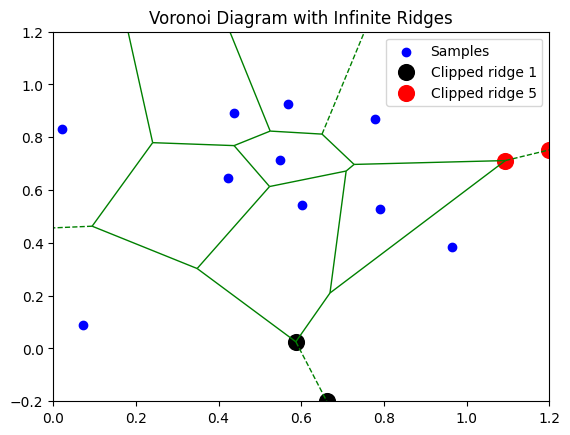

In [18]:
plt.close()
fig = plt.figure()
ax = fig.gca()
ax.scatter(points[:, 0], points[:, 1], c='blue', label='Samples')

voronoi_plot_2d(vor, show_vertices=False, show_points=False, line_colors="green", ax=ax)

colors = ["black", "red", "purple"]

for i, [ridge_idx, clipped_ridge_vertices] in enumerate(zip(ridge_indices_with_finite_vertices, finite_ridge_vertices)):
    ax.scatter(clipped_ridge_vertices[:, 0], clipped_ridge_vertices[:, 1], c=colors[i], label=f"Clipped ridge {ridge_idx}", s=2**7)

ax.set_xlim(aabbox[0])
ax.set_ylim(aabbox[1])

plt.legend()
plt.title('Voronoi Diagram with Infinite Ridges')
plt.show()

In [19]:
finite_ridge_vertices

[array([[ 0.66184473, -0.2       ],
        [ 0.58698743,  0.02550413]]),
 array([[1.09390116, 0.71174274],
        [1.2       , 0.75219314]])]